# Mushroom Classification

I am using Kaggle's [Mushroom Dataset](https://www.kaggle.com/uciml/mushroom-classification) for this project. And I am following [this post](https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival/notebook) and implementing the same approach to understand the concepts expalined thoroughly.



In [90]:
import numpy as np 
import pandas as pd
from collections import Counter
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None) # Setting for displaying max number of columns alway

In [91]:
data = pd.read_csv('mushrooms.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


**Check for any missing values**

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

No missing values. There are 21 features and a target. Since all of them are categorical, I am using Theil's U coeffiecient for finding the association of features and target.

I found [This post](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) very helpful to deal with categorical correlation.



I am just going to define the below two as functions

> **Conditional Entropy:**
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/f070a4d53ced96461310f786e6ef86e812ca1088)

> **Uncertainity Coefficient/ Theil's U:**
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/6d690a835156449c657d046586f7f5289661b56e)

In [93]:
def conditional_entropy(x,y):
    x_counter = Counter(x)
    xy_counter = Counter(zip(x,y))
    total_occurences = sum(x_counter.values())
    total = x.count()
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy]/total
        p_x = x_counter[xy[0]]/total
        entropy += p_xy * np.log(p_x/p_xy)
    return entropy
    
def theils_u(x,y):
    y_counter = Counter(y)
    total = y.count()
    p_y = list(map(lambda l:l/total,y_counter.values()))
    y_entropy = ss.entropy(p_y)
    xy_entropy = conditional_entropy(x,y)
    theilsU = (y_entropy - xy_entropy)/y_entropy
    return theilsU

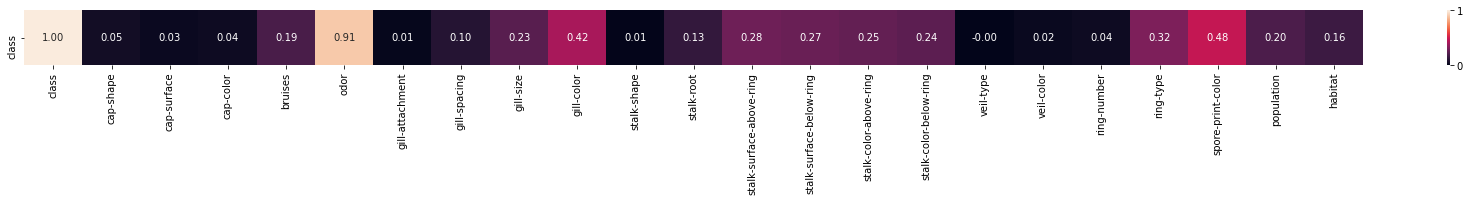

In [94]:
theilu = pd.DataFrame(index=['class'],columns=data.columns)
columns = data.columns
for j in range(0,len(columns)):
    u = theils_u(data[columns[j]],data['class'])
    theilu.loc[:,columns[j]] = u
theilu.fillna(np.nan, inplace=True)
plt.figure(figsize=(30,1))
sns.heatmap(theilu,annot=True,fmt='.2f')

From the above heatmap it's very clear that target and Odor are very much correlated. Let's understand more about the association.

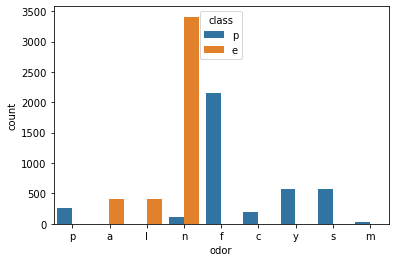

In [95]:
sns.countplot(data['odor'],hue=data['class'])

Above graph clearly shows if odor is any of \[pungent=p, pungent=p, creosote=c, fishy=y, spicy=s, musty=m] then it's Poisonous, otherwise not except if it is "odorless". If it is odorless, we can't say whether it's poisonuous or not. Let's see what other parameters will help us when mushroom is odorless.

In [96]:
odorless = data[data['odor']=='n']
odorless['odor'].value_counts() # Check if we have only odor=n

n    3528
Name: odor, dtype: int64

In [97]:
odorless.drop('odor',axis=1,inplace=True) # we don't want this column now

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [98]:
odorless.head()

,class,cap-shape,cap-surface,cap-color,bruises,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
4,e,x,s,g,f,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
14,e,x,f,n,f,f,w,b,n,t,e,s,f,w,w,p,w,o,e,k,a,g
15,e,s,f,g,f,f,c,n,k,e,e,s,s,w,w,p,w,o,p,n,y,u
16,e,f,f,w,f,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
28,e,f,f,n,f,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,y,u


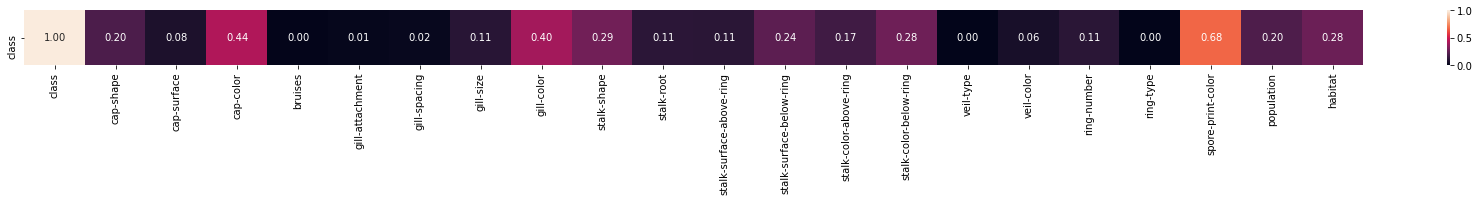

In [99]:
theilu = pd.DataFrame(index=['class'],columns=odorless.columns)
columns = odorless.columns
for j in range(0,len(columns)):
    u = theils_u(odorless[columns[j]],odorless['class'])
    theilu.loc[:,columns[j]] = u
theilu.fillna(np.nan, inplace=True)
plt.figure(figsize=(30,1))
sns.heatmap(theilu,annot=True,fmt='.2f')

Spore-print-color has maximum association with target.

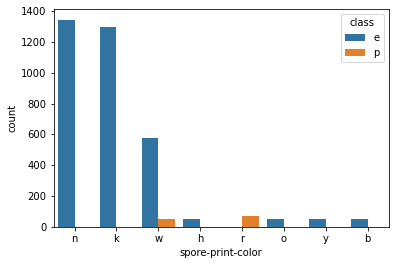

In [100]:
sns.countplot(odorless['spore-print-color'],hue=odorless['class'])

Again, we are not sure only when the spore print color is white. Let's see on a total how many samples we can classify correclty with the info we have as of now

In [101]:
odorless['spore-print-color'].value_counts()

n    1344
k    1296
w     624
r      72
b      48
y      48
o      48
h      48
Name: spore-print-color, dtype: int64

In [102]:
100 - (624/8124)*100

92.31905465288035

So just by knowing only two parameters "odor" and "spore-print-color" will allow us to classify 92.3% of samples correctly that is when I understood why experts say "Data preprocessing, understanding data, drawing insights is very much important than your model, 80-90% of work is done by this step".

Though I got 100% accuracy without all these steps as this dataset is very clean, getting to know the data first was very interesting

In [103]:
data = pd.read_csv('mushrooms.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [104]:
data_dummies = pd.get_dummies(data.iloc[:,1:],drop_first=True) #one hot encoding the data

In [105]:
y = data.iloc[:,0].replace({'p':0,'e':1})

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(data_dummies,y,test_size=0.25)

In [108]:
#model = DecisionTreeClassifier()
#model = RandomForestClassifier()
model = LogisticRegression()

In [109]:
model.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [110]:
pred = model.predict(X_test)

In [111]:
accuracy_score(Y_test,pred)

1.0

I tried 3 classifiers, all gave me accuracy one.

In [112]:
confusion_matrix(Y_test,pred)

array([[ 976,    0],
       [   0, 1055]])

In [113]:
roc_auc_score(Y_test, pred)

1.0